In [1]:
# These are helpful routines that will assist in building this book.
# You should run this block before anything else. There is no output expected.
from astrodynamicsbook.bookhelpers import *

loadLatexPreamble()

$
\def\bs{\boldsymbol}
\def\mf{\mathbf}
\def\mb{\mathbb}
\def\mc{\mathcal}
\def\rfr{\mathcal}
\def\grad{{\rm grad}}
\def\Re{{\rm Re}}
\def\Im{{\rm Im}}
\def\und{\underline}
\def\ovl{\overline}
\def\unb{\underbrace}
\def\Log{\mbox{Log}}
\def\bfomega{\bs \omega}
\def\bfalpha{\bs \alpha}
\def\da{\triangleq}
\newcommand{\leftexp}[2]{{\vphantom{#2}}^{#1}\!{#2}}
\newcommand{\leftsub}[2]{{\vphantom{#2}}_{#1}\!{#2}}
\newcommand{\omegarot}[2]{{\leftexp{\mathcal{#1}}{\boldsymbol{\omega}}^{\mathcal{#2}}}}
\newcommand{\alpharot}[2]{{\leftexp{\mathcal{#1}}{\boldsymbol{\alpha}}^{\mathcal{#2}}}}
\newcommand{\framerot}[2]{{\leftexp{\mathcal{#1}}{C}^{\mathcal{#2}}}}
\newcommand{\dframerot}[2]{{\vphantom{\dot{C}}^{\mathcal{#1}}\!{\dot{C}^{\mathcal{#2}}}}}
\newcommand{\bdot}[1]{\dot{\mathbf{#1}}}
\newcommand{\bhat}[1]{\hat{\mathbf{#1}}}
\newcommand{\mbhat}[1]{\hat{\mathbb{#1}}}
\def\iwb{\omegarot{I}{B}}
\def\iab{\alpharot{I}{B}}
\def\icb{\framerot{I}{B}}
\def\dif{\mathop{}\!\mathrm{d}}
\newcommand{\intd}[1]{\dif#1}
\newcommand{\od}[3][]{{ \frac{\dif{^{#1}}#2}{\dif{#3^{#1}}} }}			
\newcommand{\pd}[3][]{{ \frac{\partial{^{#1}}#2}{\partial{#3^{#1}}} }}	 
\newcommand{\md}[6]{{  \frac{\partial{^{#2}}#1}{\partial{#3^{#4}}\partial{#5^{#6}}} }}
\newcommand{\fddt}[2][]{{  \leftexp{\mathcal{#2}}{\frac{\dif{#1}}{\dif{t}}}  }}
\newcommand{\fdddt}[2][]{{  \leftexp{\mathcal{#2}}{\frac{\dif{^{2}#1}}{\dif{t^2}}}  }}
\newcommand{\ddt}[1][]{\fddt[#1]{I}}
$


In [2]:
# This is only here to create the navigation link:
genPrevLink()

# [Previous](<17-Open Orbit Propagation.ipynb>)

# Orbits in 3D

Recall that we have [previously asserted](<14-Keplers Laws Continued.ipynb#Keplerian-Orbit-Determination>) that *everything* about a two-body orbit can be encoded by a single, simultaneous measurement of the components of the orbital position and velocity.  This means that we are able to encode everything about the orbit using six scalar values (3 each for the position and velocity vectors), plus the time and gravitational parameter, which are assumed known.  On the other hand, as we've been going through our development of propagation approaches for the various conic sections, we've only been tracking three independent variables ($a, e, t_p$) along with a measure of the current time (provided by one of the anomaly angles) and the gravitational parameter. So, there appears to be a disconnect. 

It could be that the encoding provided by $\mf r, \mf v$ is overdetermined, and there are additional constraint equations that could be found between the elements of the two vectors.  Alternatively, it could be that we're missing something from our description of the conic section solutions. It turns out that the latter is true.  Notice that our entire discussion about vector components of the conic section solutions has been in the context of the perifocal frame.  What we're missing is the *orientation* of the perifocal frame within some arbitrary inertial frame.

<div class="alert alert-block alert-danger">
    Again, always remember that the perifocal frame <i> is</i> inertial.  It's just non-arbitrary.  What we're after here is a description of our orbit in components of some entirely arbitrary frame of reference with respect to which we make our measurements.
</div>

In order to provide ourselves with a general description of this orientation, we're going to have to back up a bit and revisit how we encode orientation.

Recall that in our original discussion of simple rotations, we defined the [basis vector DCMs](<04-Simple Rotations.ipynb#Basis-Vector-DCMs>) - those associated with rotation about one of the unit vectors defining our current reference frame.  We then proceeded to show how these could be used to define the [polar/cylindrical and spherical reference frames](<05-More Reference Frames.ipynb#The-Polar/Cylindrical-Reference-Frame>).  We are now going to generalize this idea a bit further.

# Euler Angles

We start with an assertion: any simple rotation (and thus any arbitrary DCM) can be decomposed into 3 successive simple rotations about non-repeating unit directions.  The unit directions may belong to the current reference frame (i.e., the frame to which all prior rotations have been applied - a body-fixed frame), in which case these are known as **body** or **intrinsic** rotations) or to the original (possibly inertial) frame, in which case these are **space** or **extrinsic** rotations.  Because the three DCMs involved in this decomposition are each parametrized by a single angle, what we are saying is that three angles (associated with a sequence of rotations about three specific unit directions, at least two of which are distinct from one another) can encode *any* simple rotation between two reference frames.

We are going to provide a proof of this assertion by construction, meaning that we are going to show multiple examples of this working.  In some sense, we've already proved much of this when we previously explored encodings of specific reference frames using multiple such DCMs.  The only thing new about our current assertion is that 3 is the magic number.  However, here too, we have already provided ourselves with prior evidence that this must be true, since we know that the basic encoding of a simple rotation requires three scalars - one to define an angle and two to define an axis (unit vector). 

The caveat about non-repeating axes is explained as follows:  Suppose that we take two rotations about the same axis using two different angles, $\theta_1$ and $\theta_2$:

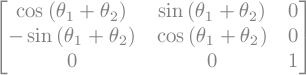

In [3]:
th1, th2 = symbols("theta_1,theta_2", real=True)
simplify(
    rotMat(3, th2) * rotMat(3, th1)
)  # remember that DCMs are composed by multiplication

The end result is a single rotation about that axis using a total angle $\theta_1 +\theta_2$.  Thus, by repeating an axis (and still limiting ourselves to just three total rotations), we lose our ability to describe a general rotation - one where we can describe the rotation by any angle about any axis.

Let's think a bit more about what it means for a DCM to be able to encode any rotation. Recall that we have already figured out the general form of a DCM as a function of the axis and angle of rotation:
$$\framerot{A}{B} =  \left[\begin{matrix}n_{1}^{2} \left(1 - \cos{\left(\theta \right)}\right) + \cos{\left(\theta \right)} & - n_{1} n_{2} \left(\cos{\left(\theta \right)} - 1\right) - n_{3} \sin{\left(\theta \right)} & - n_{1} n_{3} \left(\cos{\left(\theta \right)} - 1\right) + n_{2} \sin{\left(\theta \right)}\\- n_{1} n_{2} \left(\cos{\left(\theta \right)} - 1\right) + n_{3} \sin{\left(\theta \right)} & n_{2}^{2} \left(1 - \cos{\left(\theta \right)}\right) + \cos{\left(\theta \right)} & - n_{1} \sin{\left(\theta \right)} - n_{2} n_{3} \left(\cos{\left(\theta \right)} - 1\right)\\- n_{1} n_{3} \left(\cos{\left(\theta \right)} - 1\right) - n_{2} \sin{\left(\theta \right)} & n_{1} \sin{\left(\theta \right)} - n_{2} n_{3} \left(\cos{\left(\theta \right)} - 1\right) & n_{3}^{2} \left(1 - \cos{\left(\theta \right)}\right) + \cos{\left(\theta \right)}\end{matrix}\right]$$

for angle $\theta$ and axis $[ \bhat{n} ]_\mc A = \begin{bmatrix} n_1 & n_2 & n_3 \end{bmatrix}_\mc A^T$.  From the form of this, a general description of a DCM *must* have non-zero entries everywhere.  While we can find special cases where multiple entries equal zero (or some equal zero and some are 1), the general case requires us to accommodate all nine entries being non-zero.  There is no combination of the basis vector DCMs where the product of just two of them will generate a matrix with no zero entries.

<div class="alert alert-block alert-warning">
<b>Exercise</b><br> Demonstrate that no two basis-vector DCMs will multiply to a DCM with no zero entries.
</div>

On the other hand, *any* three of the DCMs (so long as the same one is not repeated twice in a row) will *always* generate a completely filled matrix with no zero entries. Let's take a look.

## Body Rotations

Let's start with an Euler angle set using all three axes.

<div class="alert alert-block alert-danger">
    Some authors will make a distinction between Euler angle sets using two or three distinct axes, calling the former 'proper' Euler angles and the latter 'Tait-Bryan angles' or 'Cardan angles'. Such distinctions are not hugely important when just stating the sequence of rotations uniquely identifies what you are doing.  As such, we'll usually just be calling all of these Euler angles. We should also note that some specific sets (e.g., 'yaw, pitch, and roll') also have special names for the rotation angles.
</div>

We consider a rotation of $\theta_1$ about the first unit direction of our original frame (which we'll call $\mc A$), followed by a rotation of $\theta_2$ about the second unit direction of the frame generated by the first rotation, followed by a rotation of $\theta_3$ about the third unit direction of the latest reference frame, which aligns it with our final frame, which we'll call $\mc B$. Thus:
$$\framerot{B}{A} = C_3(\theta_3)C_2(\theta_2)C_1(\theta_1)$$
recalling, as always, that successive rotations are represented by *left* matrix multiplications.  Crunching this out:

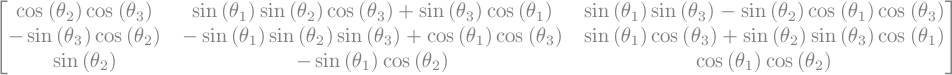

In [4]:
th1, th2, th3 = symbols("theta_1,theta_2,theta_3", real=True)
rotMat(3, th3) * rotMat(2, th2) * rotMat(1, th1)

We can take a look at a set with a repeated axis, say a 1-2-1 rotation, using the same angles:

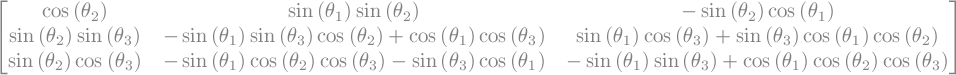

In [5]:
rotMat(1, th3) * rotMat(2, th2) * rotMat(1, th1)

A pattern begins to emerge.  All such sets (there are 12 - 6 proper and 6 Tait-Bryan) will produce a completely filled DCM with no zero elements.  One row (corresponding to the axis of the third rotation) and one column (corresponding to the axis of the first rotation) will be algebraically simpler than the rest of the terms, with the intersecting element of the row and column consisting of a single sine or cosine (positive or negative) in the intermediate rotation angle. 

<div class="alert alert-block alert-warning">
<b>Exercise</b><br> Construct some more DCMs from various body/intrinsic Euler angle sets and verify their expected structure.
</div>

In [6]:
# Room to play

## Space Rotations

While space rotations do not play an immediate role in our current discussion, for completeness sake let's knock out their formalism for future use.

<p style="text-align:center;"><img src="img/space_rotation.png" alt="Space Rotation" width="800" id="fig:space_rotation"/></p>

We'll use a starting frame $\mc A = (\bhat{a}_1, \bhat{a}_2, \bhat{a}_3)$ and initially rotate about $\bhat{a}_3$ by an angle $\theta_1$ to generate frame $\mc B$, as in the <a href="#fig:space_rotation" >figure</a>.  The DCM $\framerot{B}{A}$ is therefore equivalent to $C_3(\theta)$:
$$\framerot{B}{A} = \left[\begin{matrix}\cos{\left (\theta_{1} \right )} & \sin{\left (\theta_{1} \right )} & 0\\- \sin{\left (\theta_{1} \right )} & \cos{\left (\theta_{1} \right )} & 0\\0 & 0 & 1\end{matrix}\right]$$
We follow this with a rotation of $\theta_2$ about $\bhat{a}_1$ to generate frame $\mc C$.  How should we express $\framerot{B}{C}$?  Fortunately, we have already worked out the answer, as we can write any DCM as a function of the axis and angle of rotation.  The angle, in this case, is $\theta_2$, and the axis, which we'll call $\bhat{n}_2$, is equivalent to $\bhat{a}_1$.  All that's needed is to express $\bhat{a}_1$ in components of $\mc B$, which can be done via $\framerot{B}{A}$:

$$\left[\mf{\hat{n}}_2\right]_{\mc B} = \framerot{B}{A}\left[\mf{\hat{n}}_2\right]_{\mc A} = \left[\begin{matrix}\cos{\left (\theta_{1} \right )} & \sin{\left (\theta_{1} \right )} & 0\\- \sin{\left (\theta_{1} \right )} & \cos{\left (\theta_{1} \right )} & 0\\0 & 0 & 1\end{matrix}\right] \begin{bmatrix}1 \\ 0 \\ 0\end{bmatrix}_\mc A =  \begin{bmatrix}\cos\theta_1 \\-\sin\theta_1 \\0 \end{bmatrix}_{\mc B}$$

Note that we also could have simply read off the first column of $\framerot{B}{A}$ to get this result.

<div class="alert alert-block alert-danger">
    A note of caution:  It is easy to get confused here, because we've previously stated (and verified) that the axis of rotation has the exact same components in both frames it's rotating between.  This is still true, but the point is that $\bhat{a}_1$ is <i>not</i> the axis of rotation between $\mc A$ and $\mc B$ (that was $\bhat{a}_3$, which does have the same components in those two frames.  Now, however, we are rotating about $\bhat{a}_1$, and this unit vector <i>will</i> have the same components in both frame $\mc B$ and $\mc C$.
</div>

We plug this axis and angle into the Rodrigues equation (using another helper function `rodriguesEq` which encodes the [forward rotation form](<04-Simple Rotations.ipynb#Inverse-Rotations>) of the Rodrigues equation) to find:

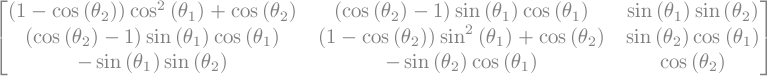

In [7]:
bCa = rotMat(3, th1)
n2 = bCa * Matrix([1, 0, 0])
cCb = rodriguesEq(n2, th2)
cCb

This looks fairly horrible, but is very straightforward to crunch out (especially if you let the computer do all the algebra).  Let's verify that everything is still self-consistent and that $\bhat{n}_2 \equiv \bhat{a}_1$ has the same components in both frame $\mc B$ and $\mc C$:

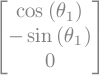

In [8]:
simplify(cCb * n2)

Amazing. Ok, now time for the really mind-blowing part.  Let's work out $\framerot{C}{A} = \framerot{C}{B}\framerot{B}{A}$:

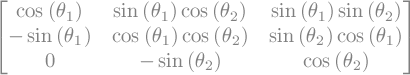

In [9]:
cCa = simplify(cCb * bCa)
cCa

Well, that's unexpectedly...simple.  It also looks a whole lot like a product of two basis-vector DCMs.  It looks that way, because it is. It is exactly equivalent to $C_3^T(-\theta_1)C_1^T(-\theta_2)$.  Look:

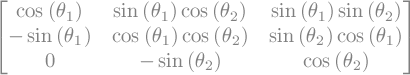

In [10]:
rotMat(3, -th1).transpose() * rotMat(1, -th2).transpose()

Remember: the DCM of a negative rotation is equivalent to the transpose of the DCM of the positive rotation, so what we're really saying is that:
$$ \framerot{C}{A} \equiv C_3(\theta_1) C_1(\theta_2)$$

In space rotations, DCMs are composed by *right* multiplication!  That's it, that's literally the only difference between computing body and space (intrinsic vs extrinsic) rotations!

<div class="alert alert-block alert-warning">
<b>Exercise</b><br> Demonstrate that, for the 3-1 space rotation explored above, a subsequent rotation by $\theta_3$ about $\bhat{a}_2$ generates a DCM equivalent to right-multiplying $\framerot{C}{A}$ by $C_2(\theta_3)$.
</div>

In [11]:
# room to explore

## General Algorithm for Extracting Euler Angles from DCMs

We can write a general algorithm for extracting the angles associated with all 24 (12 space, 12 body) Euler angle sets from any given DCM. 


#TODO: actually write out the geneeral algorithm

# Orientation of the Perifocal Frame

That rather lengthy aside complete, we are now finally ready to tackle what we came here to do: establish the orientation of the perifocal frame with respect to an arbitrary inertial frame in which we write the components of our measurements.  By convention, the perifocal frame of an orbit is a 3-1-3 body rotation from the inertial frame, using Euler angle set ($\Omega, I, \omega$).

<div class="alert alert-block alert-danger">
    Note that's this is all this is: a convention.  As we've now established, any Euler angle set can be used to describe any orientation.  We use this particular set because essentially all of the astrodynamics literature uses it, and we'd all like to (more or less) speak the same language.
</div>

<p style="text-align:center;"><img src="img/orbit_euler_angles4.png" alt="Perifocal Frame Euler Angles" width="1000" id="fig:orbit_euler_angles"/></p>

We begin with inertial frame $\mc I = (\bhat{e}_1, \bhat{e}_2, \bhat{e}_3)$ with our orbit in the $\bhat{e}_1-\bhat{e}_2$ plane.  We rotate by angle $\Omega$, known as the **longitude of the ascending node** about $\bhat{e}_3$ to generate an intermediate frame $(\bhat{n}, \bhat{e}_3 \times \bhat{n} , \bhat{e}_3)$, where $\bhat{n}$ is called the **line of nodes**. We thus have that:
$$\cos(\Omega) = \bhat{n} \cdot \bhat{e}_1$$

We next rotate by angle $I$, called the **inclination** about $\bhat{n}$, generating intermediate frame $(\bhat{n}, \bhat{h} \times \bhat{n}, \bhat{h})$, where $\bhat{h}$ is the angular momentum direction of the final orbit (and thus perpendicular to the orbital plane. This tells us that:
$$\cos(I) = \bhat{h} \cdot \bhat{e}_3$$

Finally, we rotate by angle $\omega$, the **argument of periapsis**, about $\bhat{h}$, to generate our final perifocal frame $\mc P = (\bhat{e}, \bhat{q}, \bhat{h})$ where $\bhat{e}$ is the eccentricity vector direction.  Our final rotation angle is thus:
$$\cos(\omega) = \bhat{n} \cdot \bhat{e}$$

Let's make sure we're clear on the geometry of all this.  The line of nodes is the intersection of the orbital plane ($\bhat{e}-\bhat{q}$) with the **fundamental plane** ($\bhat{e}_1-\bhat{e}_2$) of the $\mc I$ frame. $\Omega$ is the angle to the ascending node because it points to the side of the line of nodes at which the orbit is ascending (moving in the positive $\bhat{e}_3$ direction with respect to the fundamental plane).  The inclination is the angle between these two planes (and thus also the angle between $\bhat{e}_3$ and the angular momentum direction of the orbit). The argument of periapsis simply rotates the orbit within its orbital plane and gives the offset between the line of nodes and the eccentricity vector direction (which points at periapsis, and hence the name).

Both $\Omega$ and $\omega$ are defined in the range of $[0, 2\pi)$, whereas $I$ is defined in the range of $[0,\pi]$ (inclinations $>\pi$ describe the same orbits as can be found by changing the longitude of the ascending node).  Orbits with inclinations below $90^\circ$ are known as **prograde** - the orbital motion is counter-clockwise about $\bhat{e}_3$ (looking down).  Since $\bhat{e}_3$ is typically defined such that the primary body's rotation is also counter-clockwise about it, prograde motion should be interpreted as orbital motion in the same direction as the rotation of the central body about its own axis. For a visual, think of Earth's north pole direction.  The Earth rotates due East about the north pole.  Taking this direction to be $\bhat{e}_3$, an inclination of 0 gives us an **equatorial** orbit (one along the equator).  Orbit's up to 90$^\circ$ inclination will progress in the same direction as the Earth's rotation.

Orbits near $90^\circ$ inclination are known as **polar** orbits, and orbits with inclination between $90^\circ$ and $180^\circ$ are **retrograde** (orbital motion opposite the rotation of the central body).

Let's apply our newfound Euler angle formalism to fully describe all of this mathematically. First, let's define the three separate DCMs related to our three simple rotations:

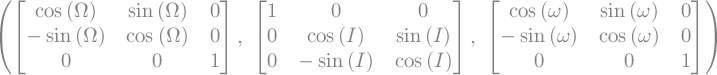

In [12]:
O, I, w = symbols("Omega, I, omega", real=True)
R1 = rotMat(3, O)
R2 = rotMat(1, I)
R3 = rotMat(3, w)
R1, R2, R3

The DCM relating $\mc I$ to $\mc P$ is the composition of these three matrices,a and is given by:

$\framerot{P}{I} = $

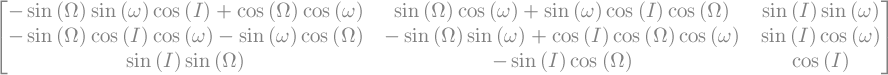

In [13]:
pCi = R3 * R2 * R1
pCi

We can now finally express the components of our orbital radius and velocity vectors in components of an arbitrary inertial frame as:
$$\left[\mf r \right]_\mc I = \framerot{I}{P}\left[\mf r \right]_\mc P \quad \textrm{and}\quad  \left[\mf v \right]_\mc I = \framerot{I}{P}\left[\mf v \right]_\mc P$$

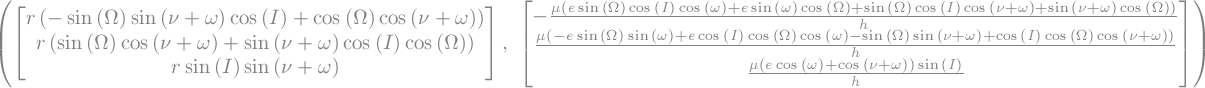

In [14]:
r, nu, mu, h, e = symbols("r,nu,mu,h,e", real=True)
iCp = pCi.transpose()
r_I = simplify(iCp * Matrix([r * cos(nu), r * sin(nu), 0]))
v_I = simplify(iCp * mu / h * Matrix([-sin(nu), e + cos(nu), 0]))
r_I, v_I

Cleaning this up a bit, we have:

$$ \left[\mf r\right]_\mc I = r\left[\begin{matrix} 
\cos{\left (\Omega \right )} \cos{\left (\nu + \omega \right )}- \sin{\left (\Omega \right )} \sin{\left (\nu + \omega \right )} \cos{\left (I \right )}  \\
 \sin{\left (\Omega \right )} \cos{\left (\nu + \omega \right )} + \sin{\left (\nu + \omega \right )} \cos{\left (I \right )} \cos{\left (\Omega \right )}\\
 \sin{\left (I \right )} \sin{\left (\nu + \omega \right )}\end{matrix}\right]_\mc I$$
 and
$$ \left[\mf v\right]_\mc I = \frac{\mu}{h}\left[\begin{matrix}- e \sin{\left(\Omega \right)} \cos{\left(I \right)} \cos{\left(\omega \right)} - e \sin{\left(\omega \right)} \cos{\left(\Omega \right)} - \sin{\left(\Omega \right)} \cos{\left(I \right)} \cos{\left(\nu + \omega \right)} - \sin{\left(\nu + \omega \right)} \cos{\left(\Omega \right)}\\- e \sin{\left(\Omega \right)} \sin{\left(\omega \right)} + e \cos{\left(I \right)} \cos{\left(\Omega \right)} \cos{\left(\omega \right)} - \sin{\left(\Omega \right)} \sin{\left(\nu + \omega \right)} + \cos{\left(I \right)} \cos{\left(\Omega \right)} \cos{\left(\nu + \omega \right)}\\\left(e \cos{\left(\omega \right)} + \cos{\left(\nu + \omega \right)}\right) \sin{\left(I \right)}\end{matrix}\right]_\mc I $$

<div class="alert alert-block alert-danger">
    As we never get tired of saying, the perifocal frame is an inertial frame.  The conversion of the components of velocity requires <i>only</i> applying the proper DCM.  There is no angular velocity between the periofocal frame and the initial inertial frame, and so the transport equation does not apply (or equivalently has no effect if applied).
</div>

## Special Cases

There are three special cases that must be considered with the use of this Euler angle set. 

1. First, there's the case of $I = 0$, which leads to a repeated rotation about $\bhat{e}_3$ of a total angle $\omega+\Omega$. In this case, there is not distinction between these two angles (the orbital plane lies in the fundamental plane and so there is no well-defined line of nodes).  We therefore define the **longitude of periapsis** (sometimes called the **longitude of pericenter**) as $\varpi = \omega+ \Omega$.

<div class="alert alert-block alert-danger">
    $\varpi$ is a variant of the greek letter $\pi$, and is literally called 'variant pi' or 'varpi'. The longitude of periapsis is therefore sometimes defined as $\pi$, but this can easily lead to much confusion with the constant of the same name (you may have heard of it).
</div>

<div class="alert alert-block alert-danger">
    $\varpi$ is frequently used even in cases where $I$ is not zero (we'll see this in a bit).  It is important to remember that in these cases, we are summing angles measured in two different planes, so that the resulting value is not a simple planar angle, but rather a compound angle in two planes.
</div>

2. The second special case to consider is the circular orbit, where $e = 0$, meaning that there is no well-defined eccentricity vector direction.  In these cases, we can simply measure the total angle between the line of nodes and the orbital radius vector, and thus define the  **argument of lattitude**: $\theta \triangleq \nu + \omega$.

<div class="alert alert-block alert-danger">
    Unlike $\varpi$, theta is always the sum of two angles measured in the same plane (the orbital plane) and so is always a well-defined planar angle.
</div>

3. Finally, we can combine the two cases, in which case we have an equatorial, circular orbit.  For this, we add all three angles to generate the **true longitude** $l \triangleq \varpi + \nu \equiv \Omega + \omega +\nu$.  In the case of an equatorial orbit, the true longitude represents the angle between $\bhat{e}_1$ and the orbital radius vector.  In all other cases, it is a compound angle summed over two different planes.

# Conversion Between Orbital Elements and Orbital State Vectors

We have now filled in the apparent gap of 3 scalars in our orbital element (sometimes known as **Keplerian** elements) description and shown that a full orbital definition must include at least six scalar values (along with the gravitational parameter of the system and time).  This means that we should now be able to convert between orbital element sets and the orbital radius and velocity vectors (collectively known as the **orbital state vectors**).  We have essentially already completed the conversion from Keplerian elements to the state vectors, but let's write it out fully in one place.

## Keplerian Elements to Orbital State Vectors

Given $\mu, a, e, t_p, \Omega, I, \omega$, we wish to find $\mf r, \mf v$ at time $t$. If $e \ne 1$:
1. Find the mean motion and angular momentum magnitude as:
$$n = \sqrt{\frac{\mu}{\vert a\vert^3}} \quad \textrm{and} \quad h = \sqrt{\mu a(1-e^2)}$$
2. Solve for the mean anomaly as $M = n(t-t_p)$ and convert to eccentric/hyperbolic anomaly via Newton-Raphson.
3. Convert the eccentric/hyperbolic anomaly to true anomaly and calculate orbital radius magnitude.
4. Solve for $\framerot{I}{P}$ by multiplying out the 3 DCMs associated with $\Omega, I, \omega$.
5. Solve for the components of $\mf r(t)$ and $\mf v(t)$ as:
$$r\framerot{I}{P}\begin{bmatrix}\cos(\nu) \\ \sin(\nu) \\ 0\end{bmatrix}_\mc P \quad \textrm{and}\quad  \frac{\mu}{h}\framerot{I}{P}\begin{bmatrix}-\sin(\nu) \\ e + \cos(\nu) \\  0\end{bmatrix}_\mc P$$

For parbolae, the procedure is almost identical, save that we need $\ell$ rather than $a,e$ as an input, we form the mean motion as $2 \sqrt{\frac{\mu}{\ell^3}}$, and we can solve for the parabolic anomaly analytically rather than via numerical iteration.

As an alternative, we can write specific forms for the state vectors for open and closed orbits as functions of the eccentric and hyperbolic anomalies.  For the elliptical case, we have:
$$\left[\mf r\right]_\mc I = a\framerot{I}{P}\begin{bmatrix}\cos(E)-e \\ \sqrt{1-e^2}\sin(E) \\ 0\end{bmatrix}_\mc P$$
and
$$\left[\mf v\right]_\mc I = \frac{a^2n}{r}\framerot{I}{P}\begin{bmatrix}-sin(E) \\ \sqrt{1-e^2}\cos(E) \\ 0\end{bmatrix}_\mc P$$

An interesting thing happens if we multiply these terms out (recalling that we [previously found](<5-Keplers Time Equation.ipynb#Kepler's-Time-Equation>) that $r = a(1-e\cos(E))$:

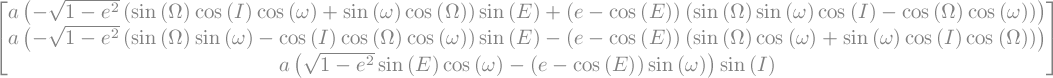

In [15]:
a, E, mu, n = symbols("a,E,mu,n", real=True)
rexp = a * (1 - e * cos(E))
rvecE = simplify(a * iCp * Matrix([cos(E) - e, sqrt(1 - e**2) * sin(E), 0]))
vvecE = simplify(
    a**2 * n / rexp * iCp * Matrix([-sin(E), sqrt(1 - e**2) * cos(E), 0])
)
rvecE

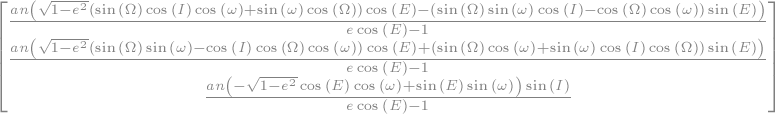

In [16]:
vvecE

If we stare at these two matrices long enough, we'll see that they both contain two common sets of terms with different multiples.  Collecting the common terms, we define:
$$A = a\begin{bmatrix}
\cos\Omega\cos\omega - \sin\Omega\sin\omega\cos I \\
\sin\Omega\cos\omega + \cos\Omega\sin\omega\cos I \\
\sin\omega\sin I 
\end{bmatrix} \quad\textrm{and}\quad
B = a\sqrt{1 - e^2} \begin{bmatrix}
-\cos\Omega\sin\omega - \sin\Omega\cos\omega\cos I \\
-\sin\Omega\sin\omega + \cos\Omega\cos\omega\cos I \\
\cos\omega\sin I
\end{bmatrix}$$
which allows us to write:
$$\begin{split}\left[\mf r\right]_\mc I &= A(\cos E - e) + B \sin E\\
\left[\mf v\right]_\mc I &= \left(\frac{n}{1 - e\cos E}\right)\left[-A \sin E + B \cos E\right] \end{split}$$

If dealing strictly with closed orbits, the utility of this form is that it eliminates the need to convert eccentric anomalies to true anomalies. 

<div class="alert alert-block alert-warning">
<b>Exercise</b><br> Find an equivalent form for the orbital state vectors of hyperbolic orbits as functions of hyperbolic anomalies.
</div>

## Orbital State Vectors to Keplerian Elements

Now for the fun part:  Given $\mu, t, \mf r(t), \mf v(t)$, find $a,e,t_p, \Omega,I, \omega$.
1. Calculate the specific orbital energy as:
$$ \mc E = \frac{\mf v \cdot \mf v}{2} - \frac{\mu}{\Vert \mf r \Vert}$$
and solve for the semi-major axis as 
$$a = -\frac{\mu}{2\mc E}$$
2. Find the angular momentum vector and line of nodes direction as:
$$ \mf h = \mf r \times \mf v \quad \textrm{and} \quad \bhat{n} = \bhat{e}_3 \times\bhat{h}$$
Remember that $[\bhat{e}_3]_\mc I = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}_\mc I^T$.  
3. Solve for the eccentricity vector as:
$$\mf e = \frac{\mf v \times \mf h}{\mu} - \mf{\hat{r}} $$
The magnitude of $\mf e$ is the eccentricity, $e$. If $e$ is 1, set $\ell = \dfrac{\mf h \cdot \mf h}{\mu}$.
4. The inclination is given by:
$$I = \cos^{-1}{\left(\bhat{h}\cdot\bhat{e}_3\right)}$$
Since $I$ is only defined in $[0,\pi]$, the arccosine expression naturally maps to the correct range.
5. The cosine of the argument of periapsis is 
$$\cos(\omega) = \bhat{e} \cdot \bhat{n}$$
however this angle has a range of $[0,2\pi)$ and so the arccosine is insufficient.  Instead, we need to use a two-argument arctangent method, meaning that we also need an independent expression for $\sin(\omega)$.  We can get one by noting that both $\bhat{n}$ and $\bhat{e}$ are orthogonal to $\bhat{h}$, meaning that:
$$\sin(\omega) = \left(\bhat{n} \times \bhat{e}\right) \cdot \bhat{h}$$
Jointly, these give us $\omega$ as:
$$\omega=\tan^{-1}{\frac{\sin{(\omega)}}{\cos{(\omega)}}}$$
but only with a two-argument arctangent calculation. If $I = 0$, this calculation will result in an undefined value (NaN), in which case it can be replaced with $\varpi$, which will equal:
$$\varpi=\tan^{-1}{\frac{\bhat{e}\cdot \bhat{e}_2}{\bhat{e}\cdot \bhat{e}_1}} $$
6. Since $\Omega$ is the angle between $\bhat{n}$ and $\bhat{e}_1$, and $\bhat{n}$ lies entirely in the $\bhat{e}_1-\bhat{e}_2$ plane, we can compute the longitude of the ascending node as:
$$\Omega=\tan^{-1}{\frac{\bhat{n}\cdot \bhat{e}_2}{\bhat{n}\cdot \bhat{e}_1}} $$
again using a two-argument arctangent.
7. $\nu$ is the angle between $\mf r$ and $\mf e$, both of which are orthogonal to $\mf h$. We can therefore use the exact same strategy as we did with $\omega$:
$$\begin{split}\cos{(\nu)} &= \left(\mf{\hat{e}}\cdot\mf{\hat{r}}\right)\\
\sin{(\nu)} &= \left(\mf{\hat{e}}\times\mf{\hat{r}}\right)\cdot\mf{\hat{h}} \end{split}$$
and
$$\nu=\tan^{-1}{\frac{\sin{(\nu)}}{\cos{(\nu)}}}$$

For the final step of finding the time of periapse passage, we will need slightly different expressions for the different conics:

### Time of Periapse Passage for Closed Orbits
Evaluate the eccentric anomaly as:
$$E = 2\tan^{-1}\left( \sqrt{\frac{1-e}{1+e}}\tan\left(\frac{\nu}{2}\right)\right)$$
and the time of periapse passage as:
$$t_p = t -\frac{E-e\sin{E}}{\sqrt{\dfrac{\mu}{a^{3}}}} $$
For closed orbits, we can also take an additional step of ensuring that the periapsis time is strictly positive (that is, finding the *next* periapsis passage).  To do so, we compute the orbital period:
$$T_p = 2\pi \sqrt{\frac{a^3}{\mu}}$$
If the evaluated $t_p$ is negative, we redefine it as:
$$t_p = kT_p + t_p$$
where $k$ is the smallest integer such that the expression evaluates to a positive value. 

### Time of Periapse Passage for Parabolic Orbits
Evaluate the parabolic anomaly and $t_p$ as:
$$\begin{split}
B &= \tan\left(\frac{\nu}{2}\right) \\
 t_p &= t -\frac{1}{2}\sqrt{\frac{\ell^3}{\mu}}\left(B + \frac{B^3}{3}\right) \,,
\end{split}
$$

### Time of Periapse Passage for Hyperbolic Orbits
This one is almost identical to the elliptical case:
$$ \begin{split} H &= 2\tanh^{-1}\left( \sqrt{\frac{e-1}{e+1}}\tan\left(\frac{\nu}{2}\right)\right) \\
t_p &= t -\frac{e\sinh{H} - H}{\sqrt{-\dfrac{\mu}{a^{3}}}}\end{split}$$


# Putting it all Together
<div class="alert alert-block alert-warning">
<b>Exercise</b><br> Implement methods for converting between Keplerian elements and orbital state vectors. Test them out by ensuring that sending the output of one in as the input of the other returns your original input values.
</div>

In [17]:
def kepler2orbstate(mu, a, e, O, I, w, tp, t):
    """Calculate orbital state vectors from Keplerian elements

    Args:
        mu (float):
            Gravitational parameter
        a (float):
            Semi-major axis (or semi-parameter is e = 1)
        e (float):
            eccentricity
        O (float):
            longitude of ascending node (rad)
        I (float):
            inclination (rad)
        w (float):
            arguments of periapsis (rad)
        tp (float):
            time of periapsis passage
        t (float):
            current time

    Returns:
        tuple:
            r (numpy.ndarray):
                Components of orbital radius
            v (numpy.ndarray):
                Components of orbital velocity
    """

    return r, v

In [18]:
def orbstate2kepler(mu, r, v, t):
    """Calculate  Keplerian elements given orbital state vectors

    Args:
        mu (float):
            Gravitational parameter
        r (numpy.ndarray):
            Components of orbital radius
        v (numpy.ndarray):
            Components of orbital velocity
        t (float):
            current time

    Returns:
        tuple:
            a (float):
                Semi-major axis (or semi-parameter is e = 1)
            e (float):
                eccentricity
            O (float):
                longitude of ascending node (rad)
            I (float):
                inclination (rad)
            w (float):
                arguments of periapsis (rad)
            tp (float):
                time of periapsis passage
    """

    return a, e, O, I, w, tp

In [19]:
# verify your methods

As usual, we also have a reference implementation of these methods built into the book for future use.  The two built-in methods have the same names as the ones you implemented above (`kepler2orbstate` and `orbstate2kepler`) but slightly different calling syntax and inputs.  You are encouraged to explore these more fully before proceeding as they'll prove highly useful in the future.  For now, let's just demonstrate that we can generate 3D orbits of all types:

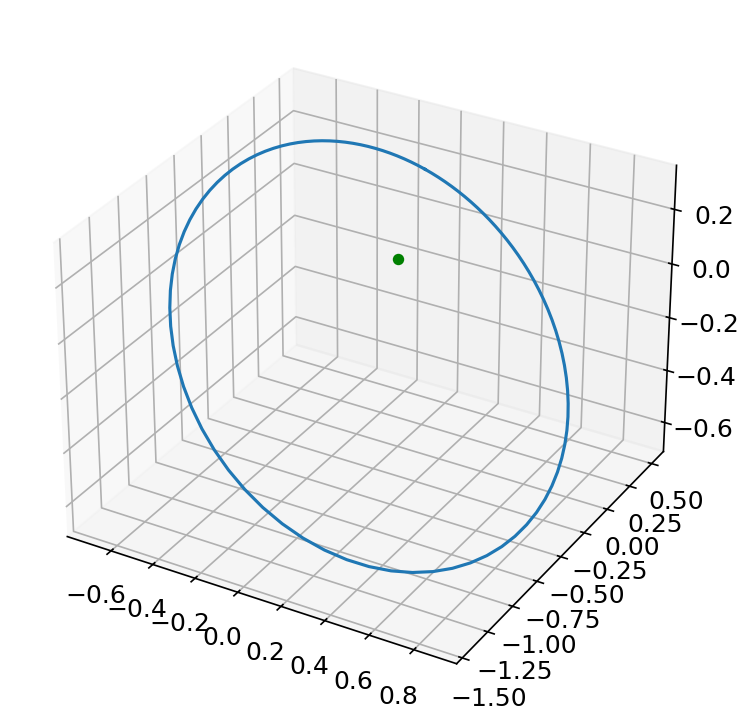

In [20]:
# grab the book's orbit state vector methods
from keplertools.fun import kepler2orbstate, orbstate2kepler

# generate an elliptical orbit in 3D
# sma = 1, e = 0.5, \Omega = 60 deg, I = 30 deg, \omega = 45 deg, mu = 1, nu \in (0,2\pi)
r, v = kepler2orbstate(
    1, 0.5, np.pi / 3, np.pi / 6, np.pi / 4, 1, np.linspace(0, 2 * np.pi, 100)
)

%matplotlib inline
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")
ax.plot(r[:, 0], r[:, 1], r[:, 2])
ax.scatter(0, 0, 0, color="g");

In [21]:
# show that we can retrieve the orbital element inputs from any of the outputs
a, e, O, I, w, tp = orbstate2kepler(r[33], v[33], 1)
a, e, O * 180 / np.pi, I * 180 / np.pi, w * 180 / np.pi

(array([1.]), array([0.5]), array([60.]), array([30.]), array([45.]))

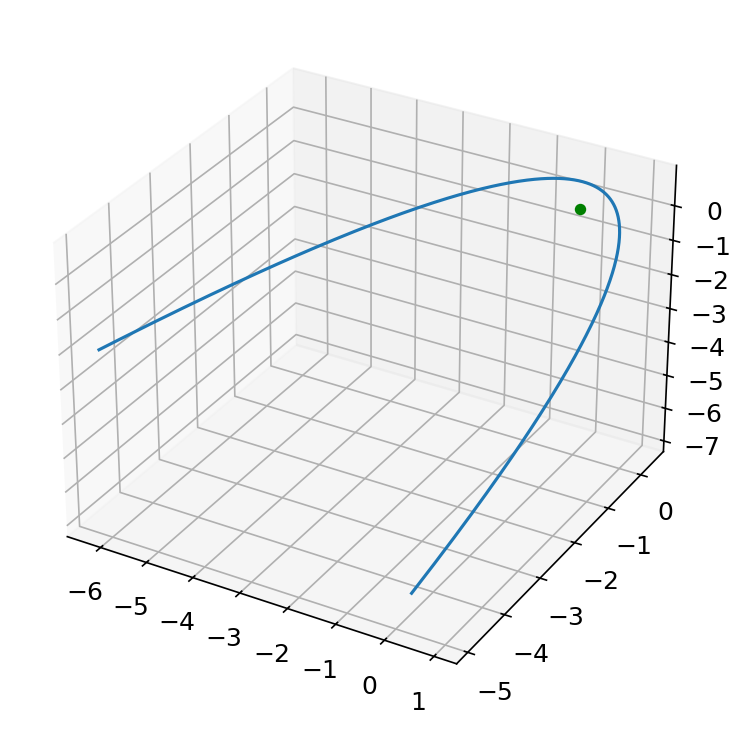

In [22]:
# parabola
# semi-parameter 1, \Omega = 30 deg, I = 60 deg, \omega = 45 deg, mu = 1
r, v = kepler2orbstate(
    1,
    1,
    np.pi / 6,
    np.pi / 3,
    np.pi / 4,
    1,
    np.linspace(-np.pi + 0.5, np.pi - 0.5, 500),
)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")
ax.plot(r[:, 0], r[:, 1], r[:, 2])
ax.scatter(0, 0, 0, color="g");

In [23]:
# show that we can retrieve the orbital element inputs from any of the outputs
l, e, O, I, w, tp = orbstate2kepler(r[42], v[42], 1)
l, e, O * 180 / np.pi, I * 180 / np.pi, w * 180 / np.pi  # first output is \ell for parabolae

(array([1.]), array([1.]), array([30.]), array([60.]), array([45.]))

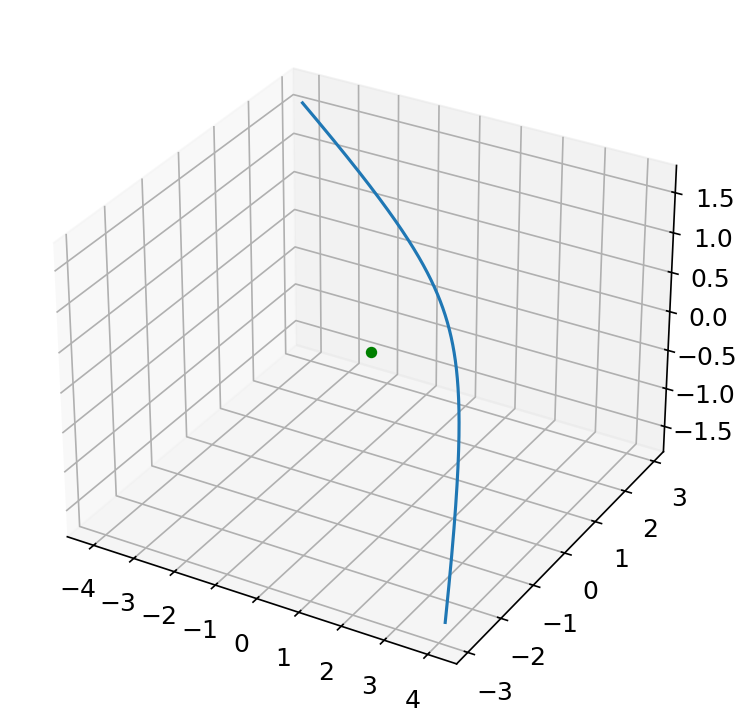

In [24]:
# hyperbola
# a = -1, e = 2.5, \Omega = 45 deg, I = 18 deg, \omega = 9 deg, mu = 1
r, v = kepler2orbstate(
    -1,
    2.5,
    np.pi / 4,
    np.pi / 10,
    np.pi / 20,
    1,
    np.linspace(-np.pi / 2, np.pi / 2, 500),
)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="3d")
ax.plot(r[:, 0], r[:, 1], r[:, 2])
ax.scatter(0, 0, 0, color="g");

In [25]:
# show that we can retrieve the orbital element inputs from any of the outputs
a, e, O, I, w, tp = orbstate2kepler(r[15], v[15], 1)
a, e, O * 180 / np.pi, I * 180 / np.pi, w * 180 / np.pi

(array([-1.]), array([2.5]), array([45.]), array([18.]), array([9.]))

In [26]:
# This is just here to generate the link to the next notebook
genNextLink()

# [Next](<19-f and g Functions.ipynb>)